## Implémentation d’un générateur de lois alpha-stables

### Objectif
Cette première étape consiste à implémenter un générateur permettant de simuler des variables aléatoires suivant une distribution alpha-stable 
𝑆
(
𝛼
,
𝛽
,
𝜎
,
𝜇
)
S(α,β,σ,μ), conformément à la description de l'Appendix B de l’article Sisson (2011). L'algorithme retenu est celui de Chambers, Mallows et Stuck (1976), qui repose sur la transformation de deux lois élémentaires.

### Générateur CMS : implémentation Python


In [1]:
import numpy as np

def sample_alpha_stable(alpha, beta, sigma=1, mu=0, size=1):
    U = np.pi * (np.random.rand(size) - 0.5)  # Uniforme sur (-π/2, π/2)
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = np.cos((1 - alpha) * U) / W
        X = numerator / denominator * (inner) ** ((1 - alpha) / alpha)
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2 * W * np.cos(U)) / ((np.pi / 2) + beta * U))
        X = B

    return sigma * X + mu



### Validation empirique : visualisation de quelques lois

Nous testons le générateur pour différentes valeurs de \(\alpha\) et \(\beta\), en représentant les histogrammes des échantillons simulés.



NameError: name 'sns' is not defined

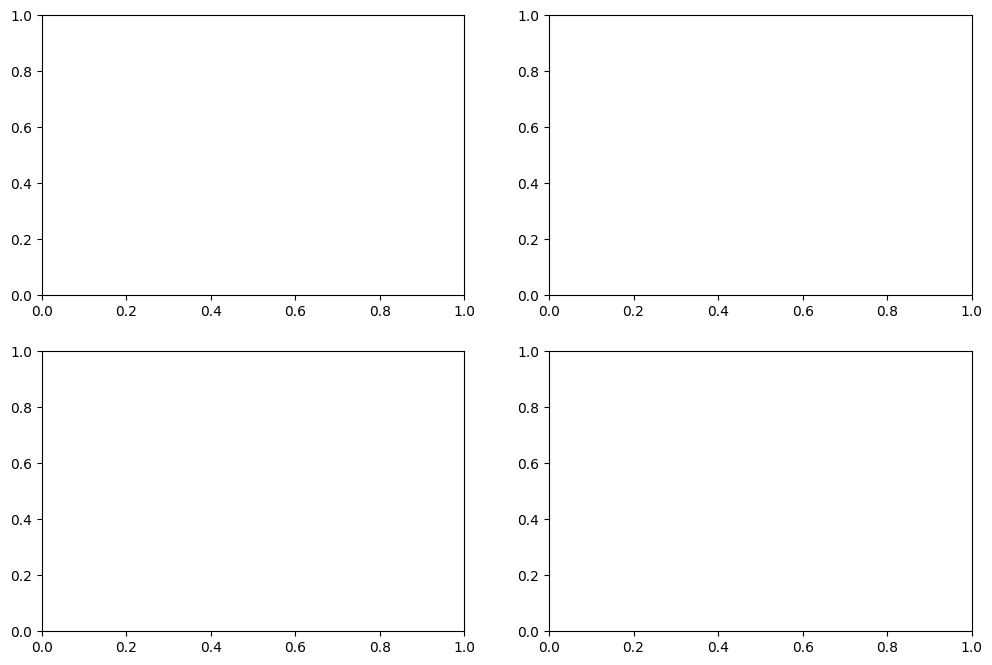

In [ ]:

# Paramètres à tester
params = [
    (2.0, 0, 1, 0, 'Gaussian (α=2)'),
    (1.0, 0, 1, 0, 'Cauchy (α=1)'),
    (1.5, 0, 1, 0, 'Symmetric (α=1.5, β=0)'),
    (1.5, 1, 1, 0, 'Skewed (α=1.5, β=1)'),
]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, (alpha, beta, sigma, mu, title) in enumerate(params):
    data = sample_alpha_stable(alpha, beta, sigma, mu, size=10000)
    
    # On élimine les valeurs extrêmes (1% aux deux extrémités) pour les cas Cauchy et Skewed
    if alpha <= 1.5:
        lower, upper = np.percentile(data, 1), np.percentile(data, 99)
        data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(data, kde=True, stat='density', ax=axs[i], bins=100)
    axs[i].set_title(title)
    axs[i].set_xlim(-10, 10)
    axs[i].set_xlabel("")
    axs[i].set_ylabel("Density")

plt.tight_layout()
plt.show()


### Validation via la fonction caractéristique

Une seconde manière de tester la validité du générateur consiste à comparer la **fonction caractéristique empirique** 


La densité des lois alpha-stables n'étant généralement pas disponible en forme fermée (sauf cas particuliers), on ne peut pas la comparer directement à une estimation empirique. En revanche, leur **fonction caractéristique** (FC) est connue explicitement et constitue un outil efficace pour valider numériquement un générateur de variables alpha-stables.

#### Définition

La fonction caractéristique d’une variable aléatoire \( X \) est définie par :

$$
\varphi_X(t) = \mathbb{E}[e^{itX}]
$$

Pour \( X \sim \mathcal{S}(\alpha, \beta, \gamma, \delta) \), la fonction caractéristique théorique est :

- Si \( \alpha =/ 1 \) :

$$
\varphi_X(t) = \exp\left( -\gamma^\alpha |t|^\alpha \left[ 1 - i\beta\, \text{sign}(t) \tan\left( \frac{\pi \alpha}{2} \right) \right] + i \delta t \right)
$$

- Si \( \alpha = 1 \) :

$$
\varphi_X(t) = \exp\left( -\gamma |t| \left[ 1 + i\beta \frac{2}{\pi} \, \text{sign}(t) \log|t| \right] + i \delta t \right)
$$

#### Méthode

On génère un grand nombre d’observations \( X_1, \dots, X_N \) avec le générateur, puis on calcule l’estimateur empirique :

$$
\hat{\varphi}_X(t) = \frac{1}{N} \sum_{j=1}^{N} e^{itX_j}
$$

On compare ensuite les resultats obtenus via les courbes :


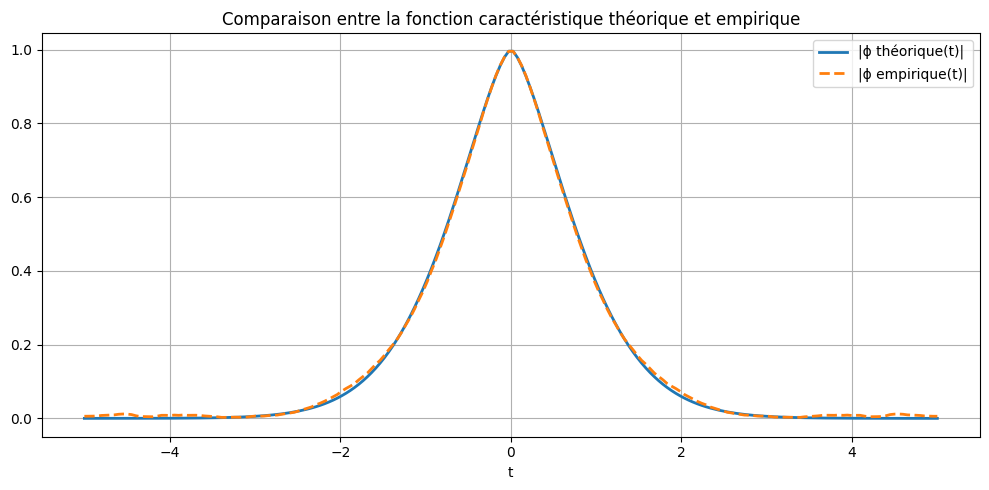

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction caractéristique théorique
def theoretical_cf(t, alpha, beta, gamma=1, delta=0):
    if alpha != 1:
        return np.exp(
            -gamma**alpha * np.abs(t)**alpha *
            (1 - 1j * beta * np.sign(t) * np.tan(np.pi * alpha / 2)) +
            1j * delta * t
        )
    else:
        return np.exp(
            -gamma * np.abs(t) *
            (1 + 1j * beta * (2 / np.pi) * np.sign(t) * np.log(np.abs(t))) +
            1j * delta * t
        )

# Estimateur empirique de la fonction caractéristique
def empirical_cf(t_vals, samples):
    return np.array([np.mean(np.exp(1j * t * samples)) for t in t_vals])

# Paramètres de test
alpha = 1.5
beta = 0
gamma = 1
delta = 0
N = 10_000

# Génération d'échantillons
samples = sample_alpha_stable(alpha, beta, sigma, mu, size=N)

# Grille de t
t_vals = np.linspace(-5, 5, 200)

# Fonction caractéristique théorique et empirique
phi_theo = theoretical_cf(t_vals, alpha, beta, gamma, delta)
phi_emp = empirical_cf(t_vals, samples)

# Tracé des modules
plt.figure(figsize=(10, 5))
plt.plot(t_vals, np.abs(phi_theo), label="|ϕ théorique(t)|", lw=2)
plt.plot(t_vals, np.abs(phi_emp), label="|ϕ empirique(t)|", lw=2, linestyle="--")
plt.xlabel("t")
plt.title("Comparaison entre la fonction caractéristique théorique et empirique")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Intégration de RQMC pour la simulation de lois alpha-stables

Dans cette partie, nous allons adapter notre générateur alpha-stable en utilisant des **points RQMC (Randomized Quasi-Monte Carlo)**. Nous allons comparer par la suite les résultats obtenus par RQMC avec ceux de Monte Carlo standard.

Les générateurs RQMC, comme **Sobol**, sont conçus pour répartir les points d’échantillonnage de manière plus uniforme dans l’espace, ce qui permet de mieux couvrir l’ensemble de l’intervalle d’intégration avec moins de points, tout en conservant des propriétés statistiques intéressantes. Cela se traduit par une estimation plus précise des intégrales, ce qui est particulièrement utile dans le cadre des simulations de distributions alpha-stables.

L’idée ici est de **générer les points uniformes** nécessaires pour transformer ensuite ces points en variables suivant une **loi uniforme** sur l'intervalle `(-π/2, π/2)` et une **loi exponentielle**.

- **Loi uniforme** : Cela est assez simple à réaliser en utilisant directement les points générés par RQMC, qui sont uniformément distribués dans l'intervalle `[0, 1]`. En les transformant de manière appropriée, on obtient les points uniformément distribués sur `(-π/2, π/2)`.

- **Loi exponentielle** : Pour la génération de la loi exponentielle, nous avons utilisé le **théorème de l'inversion**. En partant du fait que si `U ~ Uniform(0, 1)`, la transformation inverse `W = -log(1 - U)` permet d’obtenir une variable suivant une loi exponentielle de paramètre `λ = 1`.

In [ ]:
from scipy.stats import qmc 

# Générateur RQMC
def generate_rqmc_points(n_samples, dim):
    """
    Génère des points RQMC (par exemple, avec la suite de Sobol) dans un espace [0, 1].
    """
    sampler = qmc.Sobol(d=dim, scramble=True)
    points = sampler.random(n_samples)
    return points
#Fonction ci-dessous à revoir : utilisation de rqmc dans exponenetielle aussi
def sample_alpha_stable_with_rqmc_test(alpha, beta, sigma=1, mu=0, size=1):
    """
    Génère des échantillons alpha-stables à l'aide de RQMC pour générer des points uniformes et exponentiels.
    """
    # Utilisation de RQMC pour générer des points
    rqmc_points = generate_rqmc_points(size, 1) 
    
    # Transformation pour obtenir la loi uniforme U sur (-pi/2, pi/2)
    U = np.pi * (rqmc_points - 0.5) 
    
    # Transformation inverse pour obtenir W suivant une loi exponentielle
    W = -np.log(1 - rqmc_points)  # D'après théorème de l'inversion

    # Calcul de l'échantillon alpha-stable
    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = (np.cos((1 - alpha) * U)) / W
        X = numerator / denominator * (inner ** ((1 - alpha) / alpha))
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2) * W * np.cos(U)) / ((np.pi / 2) + beta * U)
        X = B

    # Retourner l'échantillon alpha-stable final avec les paramètres sigma et mu
    return sigma * X + mu

In [17]:
def sample_alpha_stable_with_rqmc(alpha, beta, sigma=1, mu=0, size=1):
    """
    Génère des échantillons alpha-stables à l'aide de RQMC pour générer des points uniformes et exponentiels.
    """
    # Utilisation de RQMC pour générer des points
    rqmc_points = generate_rqmc_points(size, 1) 
    
    # Transformation pour obtenir la loi uniforme U sur (-pi/2, pi/2)
    U = np.pi * (rqmc_points - 0.5) 
    W = np.random.exponential(scale=1.0, size=size)  # Exp(1)

    
    # Calcul de l'échantillon alpha-stable
    if alpha != 1:
        numerator = np.sin(alpha * U)
        denominator = (np.cos(U))**(1 / alpha)
        inner = (np.cos((1 - alpha) * U)) / W
        X = numerator / denominator * (inner ** ((1 - alpha) / alpha))
    else:
        B = (2 / np.pi) * ((np.pi / 2) + beta * U) * np.tan(U) - \
            beta * np.log((np.pi / 2) * W * np.cos(U)) / ((np.pi / 2) + beta * U)
        X = B

    # Retourner l'échantillon alpha-stable final avec les paramètres sigma et mu
    return sigma * X + mu

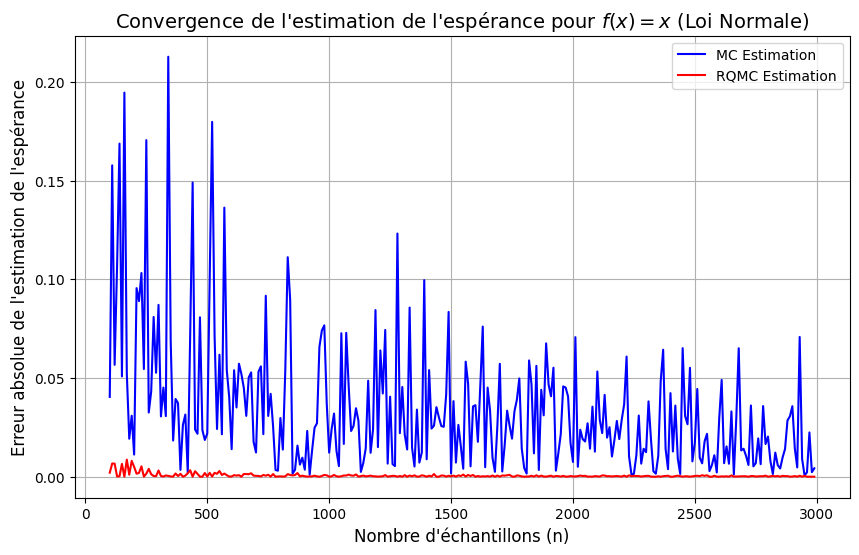

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction à intégrer
def f(x):
    return x

# Estimation de l'espérance avec Monte Carlo standard
def estimate_expectation_monte_carlo(alpha, beta, sigma, mu, n_samples):
    samples = sample_alpha_stable(alpha, beta, sigma, mu, size=n_samples) 
    return np.mean(f(samples)) 

# Estimation de l'espérance avec RQMC
def estimate_expectation_rqmc(alpha, beta, sigma, mu, n_samples):
    samples = sample_alpha_stable_with_rqmc(alpha, beta, sigma, mu, size=n_samples)
    return np.mean(f(samples)) 

# Comparaison des méthodes pour différents nombres d'échantillons
sample_sizes = np.arange(100, 3000, 10) 
mc_estimations = []
rqmc_estimations = []

mu = 0  
sigma = 1  
alpha = 2  # Loi normale (alpha=2)
beta = 0
for n in sample_sizes:
    mc_est = estimate_expectation_monte_carlo(alpha, beta, sigma, mu, n)
    rqmc_est = estimate_expectation_rqmc(alpha,beta, sigma, mu,  n)
    
    mc_estimations.append(mc_est)
    rqmc_estimations.append(rqmc_est)


plt.figure(figsize=(10, 6))

# Courbes pour Monte Carlo classique et RQMC
plt.plot(sample_sizes, np.abs(np.array(mc_estimations)), label='MC Estimation', color='b')
plt.plot(sample_sizes, np.abs(np.array(rqmc_estimations)), label='RQMC Estimation', color='r')

plt.title('Convergence de l\'estimation de l\'espérance pour $f(x) = x$ (Loi Normale)', fontsize=14)
plt.xlabel('Nombre d\'échantillons (n)', fontsize=12)
plt.ylabel('Erreur absolue de l\'estimation de l\'espérance', fontsize=12)
plt.legend()
plt.grid(True)

plt.show()
